In [ ]:
from google.colab import files
files.upload()
import os

Saving kaggle.json to kaggle.json
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 70, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1493, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1447, in dataset_download_files
    self.download_file(response, outfile, quiet, not force)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1834, in download_file
    size = int(response.headers['Content-Length'])
  File "/usr/local/lib/python3.10/dist-packages/urllib3/_collections.py", line 258, in __getitem__
    val = self._container[key.lower()]
KeyError: 'content-length'


In [ ]:
!unzip /content/drive/MyDrive/CharacterRecognitionModel/archive.zip
# !rm /content/drive/MyDrive/CharacterRecog/archive.zip

In [ ]:
!pip install pydicom
import shutil
import pydicom
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import gc
from tqdm import tqdm


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB2, EfficientNetB1
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout, Flatten

from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00


In [ ]:
train_datagen = ImageDataGenerator(
      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/content/DevanagariHandwrittenCharacterDataset/Train',
        target_size=(32, 32),
        batch_size=64)

Found 78200 images belonging to 46 classes.


In [ ]:
test_datagen = ImageDataGenerator(
      rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
        '/content/DevanagariHandwrittenCharacterDataset/Test',
        target_size=(32, 32),
        batch_size=64)

Found 13800 images belonging to 46 classes.


In [ ]:
num_of_characters = 46

In [ ]:
image = cv2.imread('/content/DevanagariHandwrittenCharacterDataset/Train/character_13_daa/10670.png')
image.shape

(32, 32, 3)

In [ ]:
initializer = tf.keras.initializers.HeNormal()

In [ ]:
input_data = Input(shape=(32, 32, 3), name='input')

#CNN
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer=initializer)(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer=initializer)(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)


# CNN to FCL
inner = Flatten()(inner)

inner = Dense(256, activation='relu', kernel_initializer=initializer, name='dense1')(inner)
#inner = Dropout(0.3)(inner)
inner = Dense(128, activation='relu', kernel_initializer=initializer, name='dense2')(inner)
#inner = Dropout(0.3)(inner)
inner = Dense(64, activation='relu', kernel_initializer=initializer, name='dense3')(inner)
inner = Dense(32, activation='relu', kernel_initializer=initializer, name='dense8')(inner)
## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense4')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max1 (MaxPooling2D)         (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                             

In [ ]:
inputs = layers.Input(shape=(32, 32, 3))
outputs = EfficientNetB0(include_top=True, weights=None, classes=num_of_characters,input_shape=(32, 32, 3))(inputs)


model = tf.keras.Model(inputs, outputs)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss,
              optimizer='Adam',
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

filepath = "/content/drive/MyDrive/CharacterRecognitionModel/saved-model-{epoch: 02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=True,save_freq='epoch')

In [ ]:
history = model.fit(
      train_generator,
      epochs=35,
      validation_data=test_generator,
      validation_steps=4,
      callbacks=[checkpoint,learning_rate_reduction],
      verbose=1,
      )

Epoch 1/35
1222/1222 [==============================] - ETA: 0s - loss: 3.9292 - accuracy: 0.0570
Epoch 1: val_loss improved from inf to 12.37983, saving model to /content/drive/MyDrive/CharacterRecognitionModel/saved-model- 1-0.05.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1222/1222 [==============================] - 206s 122ms/step - loss: 3.9292 - accuracy: 0.0570 - val_loss: 12.3798 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 2/35
1222/1222 [==============================] - ETA: 0s - loss: 3.4239 - accuracy: 0.1209
Epoch 2: val_loss improved from 12.37983 to 6.02455, saving model to /content/drive/MyDrive/CharacterRecognitionModel/saved-model- 2-0.10.hdf5
1222/1222 [==============================] - 143s 117ms/step - loss: 3.4239 - accuracy: 0.1209 - val_loss: 6.0245 - val_accuracy: 0.0977 - lr: 0.0010
Epoch 3/35
1222/1222 [==============================] - ETA: 0s - loss: 3.3361 - accuracy: 0.1425
Epoch 3: val_loss did not improve from 6.02455
1222/1222 [==============================] - 142s 116ms/step - loss: 3.3361 - accuracy: 0.1425 - val_loss: 21.8916 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 4/35
1222/1222 [==============================] - ETA: 0s - loss: 2.9519 - accuracy: 0.1934
Epoch 4: val_loss improved from 6.02455 to 3.25313, saving model

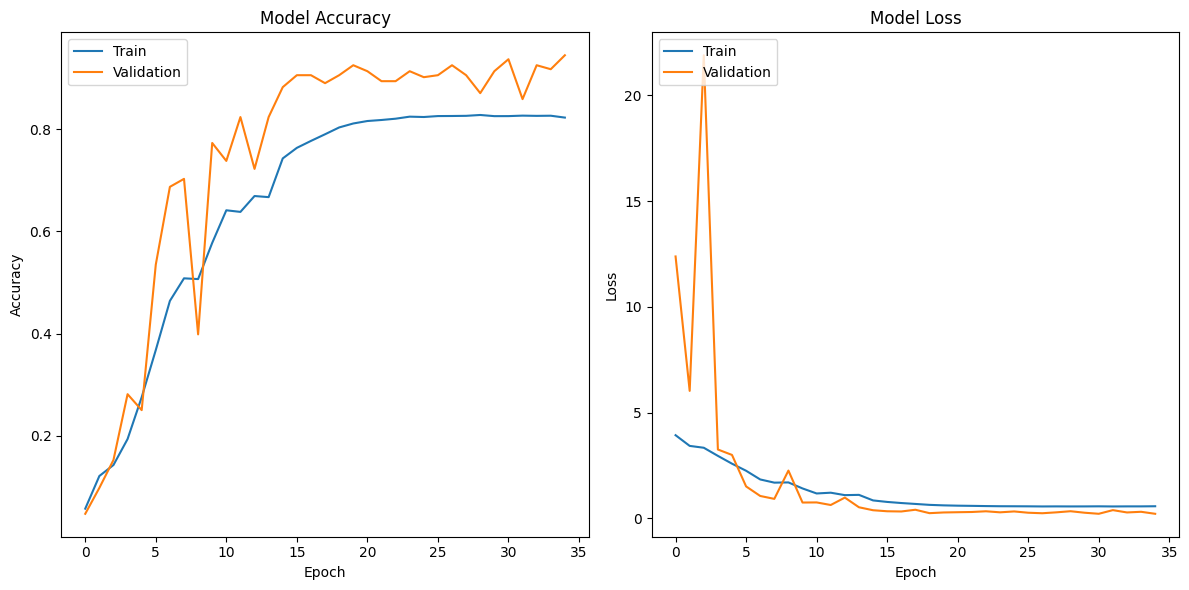

In [ ]:
# Visualizing training and validation metrics
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/CharacterRecognitionModel/model.h5")
model.load_weights("/content/drive/MyDrive/CharacterRecognitionModel/model.h5")
loss, acc = model.evaluate(test_generator, steps=3, verbose=0)
acc = acc *100
print(f"accuracy is: {acc:.2f}%")

accuracy is: 92.19%
